In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
tf.get_logger().setLevel('INFO')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

mpl.rcParams['figure.figsize'] = 20, 10

ImportError: No module named 'keras'

In [0]:
def quantile_error(q, y, f):
    #e = (y - f)
    e = (f - y)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), axis=-1)

In [0]:
def lstm_dqr_model(X, N_taus=100, training=True):
    # define model
    i = tf.keras.Input(shape=(X.shape[-1]))[:,tf.newaxis,:] #[bs, 1, ts]
    if training:
      tau = tf.random.uniform((tf.shape(i)[0],N_taus, 1), minval=1e-2, maxval=1.-1e-2) # [bs, N_taus, 1]
    else:
      tau = tf.keras.Input(shape=(1,))

    #RESHAPE de INPUT y TAU
    i_b = tf.repeat(i, N_taus, axis=1)
    tau_b = tf.repeat(tau, X.shape[-1], axis=-1)
    
    input_tau = tf.keras.layers.concatenate([i_b, tau_b], axis=-1)
    input_tau = tf.reshape(input_tau, [-1, X.shape[-1]]) #[bs * N_taus, ts]

    # model = tf.keras.layers.LSTM(50, activation='relu')(i)
    hidden = tf.keras.layers.LSTM(50, activation='relu')(input_tau) #[bs * N_taus, 50]
    hidden = tf.keras.layers.Dense(1)(hidden) #[bs * N_taus, 1] ---> [bs, N_taus, 1]
    # model = tf.keras.layers.Dense(N_quantiles)(model)

    output_tau = tf.keras.layers.concatenate([hidden, tau_b], axis=-1)

    model = tf.keras.Model(inputs = i, outputs = output_tau)

    # q = shape N
    model.compile(optimizer='adagrad', loss=quantile_error)
    return model

In [0]:
def generate_synth_tseries(t0: int, series_lenght: int, num_ts: int, period: int, freq: int, noise_level: float) -> pd.DataFrame:
    """
    Generate n seasonal synthetic time series starting at t0. It allows to control the series length, seasonal period,
    time frequency resolution and added noise
    """
    time_series = []
    for k in range(num_ts):
        level = 10 * np.random.rand()
        seas_amplitude = (0.1 + 0.3*np.random.rand()) * level
        sig = noise_level * level # noise parameter (constant in time)
        time_ticks = np.array(range(series_lenght))
        source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
        noise = sig*np.random.randn(series_lenght)
        data = source + noise
        index = pd.date_range(start=t0, freq=freq, periods=series_lenght)
        time_series.append(pd.Series(data=data, index=index))
    time_series_df = pd.DataFrame(time_series)
    return time_series_df

In [0]:
def split_sequence(sequence: np.ndarray, n_steps: int) -> (np.ndarray, np.ndarray):
    '''
    It splits a given univariate sequence into multiple samples X where each sample has a specified
    number of time steps and the output y is a single time step
    Ref: https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/
    '''
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [0]:
def plot_ts_forecast(ts_Y_train, ts_Y_test, yhat):
    forecast_h = len(yhat)
    train_window = len(ts_Y_train)
    x_length = forecast_h+train_window
    aa=[x for x in range(x_length)]
    plt.figure(figsize=(20,8))
    plt.plot(aa[:train_window], ts_Y_train, marker='.', label="train")
    plt.plot(aa[train_window:], ts_Y_test, marker='.', label="test")
    plt.plot(aa[train_window:], yhat.reshape(-1), 'r', label="prediction")
    plt.tight_layout()
    plt.subplots_adjust(left=0.07)
    plt.xlabel('time step', size=15)
    plt.legend(fontsize=15)
    plt.show()


In [0]:
# ------Time series
t0 = '2016-01-01 00:00:00'
freq = 'H'
num_ts = 1

# default - changed in each experiemnt to test different behaviors
noise_level = 0.05
period = 14

# train, test
total_days = 20
tseries_length = total_days * 24 # hourly freq
train_days = 15 * 24

# ------LSTM
n_features = 1 # We are working with univariate series so the number of features is 1
n_steps=2 # we will work with a batch of 2 time steps

# ----- Deep Quantile Regression
QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]

In [0]:
time_series_df = generate_synth_tseries(t0, tseries_length, num_ts, period, freq, noise_level)

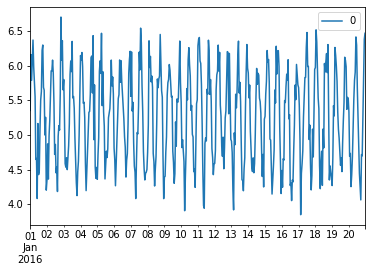

In [0]:
time_series_df.T.plot()

In [0]:
train_ts = time_series_df.iloc[:, 0:train_days]
test_ts = time_series_df.iloc[:,train_days-1:-1]
ts_X_test, ts_Y_test = split_sequence(test_ts.values[0], n_steps)
ts_X_train, ts_Y_train = split_sequence(train_ts.values[0], n_steps)
# reshape as input for the lstm
X = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], n_features)) 

In [0]:
def quantile_error(y_true, parameters):
  """
  y_true: [bs, 1]
  """
  mu = parameters[:,:,:1] #[bs, N_taus, 1]
  tau = parameters[:,:,-1:] #[bs, N_taus, 1]
  y_1 = y_true[:,tf.newaxis,:] #[bs, 1, 1]
  y = tf.repeat(y_1,tf.shape(mu)[1],axis=1, name='repeat_-1') #[bs, N_taus, 1]
  return tf.reduce_mean(tf.maximum(tau*(y-mu),(tau-1.)*(y-mu)))


class Implicit_QR(tf.keras.Model):
  def __init__(self):
    super(Implicit_QR, self).__init__()
    self.h_1 = tf.keras.layers.LSTM(50, activation='relu', name='LSTM_01')
    self.h_2 = tf.keras.layers.Dense(1)

  def call(self, inputs, N_taus=100, training=True):
    """
    inputs: [bs, ts, f]
    """

    if training:
      tau = tf.random.uniform((tf.shape(inputs)[0],N_taus, 1, 1), minval=1e-2, maxval=1.-1e-2) # [bs, N_taus, 1, 1]
    else:
      tau = tf.keras.Input(shape=(1,)) #[N_taus, 1]
      tau = tf.repeat(tf.reshape(tau,(1,-1,1,1), name='reshape_0'), tf.shape(inputs)[0], name='repeat_0') # [bs, N_taus, 1, 1]
    
    i_1 = tf.keras.backend.expand_dims(inputs,axis=1) #[bs, 1, ts, f]

    #RESHAPE de INPUT y TAU
    i_b = tf.repeat(i_1, N_taus, axis=1, name='repeat_1') #[bs, N_taus, ts, f]
    
    #tf.debugging.assert_equal(tf.shape(tau)[1:], [N_taus, 1,1])
    print(tau[:,:,0].shape)
    tau_b = tf.repeat(tau, inputs.shape[1], axis=2, name='repeat_2') #[bs, N_taus, ts, 1]
    
    input_tau = tf.keras.layers.concatenate([i_b, tau_b], axis=-1) # [bs, N_taus, ts, fs+1]
    input_tau = tf.reshape(input_tau, [-1, tf.shape(inputs)[1], X.shape[-1]+1], name='repeat_3') #[bs * N_taus, ts, fs+1]

    # Model
    hidden_1 = self.h_1(input_tau)
    hidden_2 = self.h_2(hidden_1)

    output_tau = tf.keras.layers.concatenate([tf.reshape(hidden_2, tf.shape(tau[...,0]), name='reshape_4'), tau[...,0]], axis=-1)

    return output_tau

In [0]:
model = Implicit_QR()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss = quantile_error)
quantile_error(y[:100].astype('float32'), model(X[:100])).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(100, 100, 1)


TensorShape([])

In [0]:
model.summary()

Model: "implicit_qr_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_01 (LSTM)               multiple                  10600     
_________________________________________________________________
dense_33 (Dense)             multiple                  51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________


In [0]:
X.shape, y.shape

((358, 2, 1), (358, 1))

In [0]:
es = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X, y, validation_split=0.1,verbose=1, epochs=10000, callbacks=[es])

from matplotlib import pyplot as plt
plt.plot(history.history['val_loss'])

Epoch 1/10000
(None, 100, 1)
(None, 100, 1)
 9/11 [=======================>......] - ETA: 0s - loss: 2.4946

ValueError: ignored

In [0]:
model(X).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([358, 100, 2])

In [0]:
y[:,tf.newaxis,:,tf.newaxis].shape

(358, 1, 1, 1)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(), dtype=float32, numpy=2.604759>

In [0]:
tf.repeat(np.zeros((10,3,1)),30,axis=-1).shape

TensorShape([10, 3, 30])

In [0]:
X.shape

(358, 2, 1)

In [0]:
model = Implicit_QR()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss = quantile_error)

In [0]:
y = ts_Y_train.reshape((ts_Y_train.shape[0], 1))

In [0]:
X.shape

(358, 2, 1)

In [0]:
es = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X, y, validation_split=0.1,verbose=1, epochs=10000, callbacks=[es])

from matplotlib import pyplot as plt
plt.plot(history.history['val_loss'])

Epoch 1/10000


InvalidArgumentError: ignored

In [0]:
model(X, N_taus=105, training=True).shape

TensorShape([358, 105, 2])

In [0]:
ts_X_train.shape, ts_Y_train.shape, y.shape

((358, 2), (358,), (358, 1))

Epoch 1/10000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Tensor("implicit_qr_8/dense_8/BiasAdd:0", shape=(35800, 1), dtype=float32)
Tensor("implicit_qr_8/concatenate_1/concat:0", shape=(358, 100, 2), dtype=float32)
Tensor("implicit_qr_8/dense_8/BiasAdd:0", shape=(35800, 1), dtype=float32)
Tensor("implicit_qr_8/concatenate_1/concat:0", shape=(358, 100, 2), dtype=float32)


InvalidArgumentError: ignored

In [0]:
X.shape

(358, 2, 1)

In [0]:
X.shape

(358, 2, 1)

In [0]:
model = lstm_dqr_model(X)

ValueError: ignored

In [0]:
x_input = ts_X_test
x_input = x_input.reshape((ts_X_test.shape[0], ts_X_test.shape[1], n_features))
yhat = model.predict(x_input, verbose=0)

In [0]:
plot_ts_forecast(ts_Y_train, ts_Y_test, yhat)